I think a SWIN transformer might be good, it seems like it has versatile use cases. I think what I am doing is semantic segmentation, but instead of pixel values of 0 and 1, I think it is a distribution between 0 and 1 for a heatmap of KPs.

https://github.com/microsoft/Swin-Transformer

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import timm
import os

This dataset class loads grayscale images and heatmap labels, transforming the grayscale images to 3 channels (to match the Swin Transformer’s expectations). - not sure if this is a great way to do it, should figure out how to just keep the original RGB structure before Raghav dataset creation.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define Dataset class for loading facemap softlabels and converting them to hard labels
class FaceMapDataset(Dataset):
    def __init__(self, data_file="data/facemap_softlabels.pt", transform=None):
        super().__init__()
        self.transform = transform
        self.data, _, self.targets = torch.load(data_file)
        
    ################## Uncomment for hard labels #####################
        #self.targets = self.convert_soft_to_hard_labels(self.targets)
    #def convert_soft_to_hard_labels(self, soft_labels):
    #    hard_labels = (soft_labels > 0.01).float()  
    #    return hard_labels
    ##################################################################

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        image, label = self.data[index].clone(), self.targets[index].clone()         
        # Convert grayscale to 3-channel by repeating the single channel - this might not be the best way, but until i figure out how to maintain the 3 channels in Raghav's original dataset creation script
        image = image.repeat(3, 1, 1)  # Converts (1, 224, 224) to (3, 224, 224)

        # Apply transformations if provided (e.g., flipping for augmentation)
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Initialize the dataset with transformations for resizing and normalization if needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if required (optional)
])

dataset = FaceMapDataset(data_file="data/facemap_softlabels.pt", transform=transform)

# Define DataLoader
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Trying a SWIN model with some changes to output layer to hopefully match the output it should produce (224x224 heatmap of KP likely placement)

In [6]:

class SimpleSwinHeatmap(nn.Module):
    def __init__(self, pretrained=True):
        super(SimpleSwinHeatmap, self).__init__()
        
        # Load the Swin Transformer model as a feature extractor
        self.encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained, features_only=True, out_indices=(3,))
        
        # Final convolutional layer to reduce to single-channel heatmap output
        self.conv_out = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=1)  # Corrected input channels to 1024, kernel size 7 because that is what the model is trained with!


    def forward(self, x):
        # Extract features from the last stage of Swin
        x = self.encoder(x)[0]  # Access the last feature map with appropriate dimensions
        
        # Rearrange dimensions if needed
        if x.shape[1] != 1024:  # Assuming the encoder output has shape (batch_size, 7, 7, 1024)
            x = x.permute(0, 3, 2, 1)  # Change shape to (batch_size, 1024, 7, 7)
        
        # Apply the final convolution to produce a single-channel heatmap
        x = self.conv_out(x)
        
        # Resize to match the target output size if necessary
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#import torch_directml
#device = torch_directml.device()
model = SimpleSwinHeatmap().to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [11]:
# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        i = 0
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss and backpropagate
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        i += 1

# Save the model
    torch.save(model.state_dict(), 'simple_swin_heatmap.pth')

Epoch 1/300, Loss: 0.001871671760454774
Epoch 1/300, Loss: 0.0018748575821518898
Epoch 1/300, Loss: 0.0018673465820029378
Epoch 1/300, Loss: 0.0018286514095962048
Epoch 1/300, Loss: 0.001841641147620976
Epoch 1/300, Loss: 0.0018611233681440353
Epoch 1/300, Loss: 0.0018476040568202734
Epoch 1/300, Loss: 0.0018308548023924232
Epoch 1/300, Loss: 0.00186344760004431
Epoch 1/300, Loss: 0.0018515430856496096
Epoch 1/300, Loss: 0.0018264285754412413
Epoch 1/300, Loss: 0.001859414391219616
Epoch 1/300, Loss: 0.001853456604294479
Epoch 1/300, Loss: 0.0018500766018405557
Epoch 1/300, Loss: 0.0018673886079341173
Epoch 2/300, Loss: 0.0018671405268833041
Epoch 2/300, Loss: 0.001842212863266468
Epoch 2/300, Loss: 0.0018608225509524345
Epoch 2/300, Loss: 0.0018586523365229368
Epoch 2/300, Loss: 0.001839676289819181
Epoch 2/300, Loss: 0.0018561886390671134
Epoch 2/300, Loss: 0.0018496672855690122
Epoch 2/300, Loss: 0.0018680439097806811
Epoch 2/300, Loss: 0.001870773732662201
Epoch 2/300, Loss: 0.0018

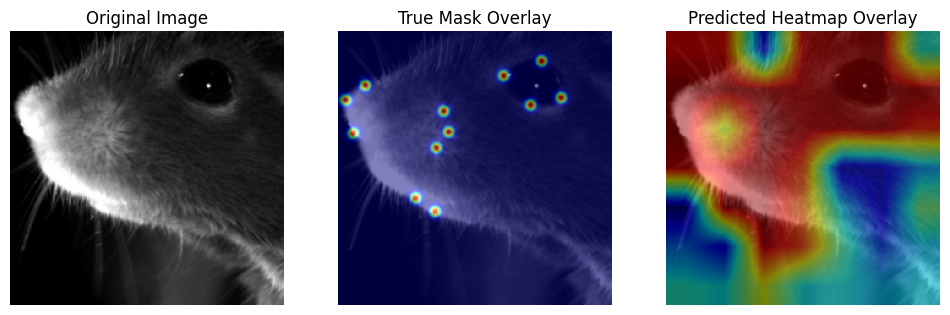

In [12]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Define the test dataset
test_dataset = FaceMapDataset(data_file="data/facemap_softlabels.pt", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the trained model weights
#model = SimpleSwinHeatmap().to(device)
#model.load_state_dict(torch.load('simple_swin_heatmap.pth'))

# Function to overlay predictions on images
def plot_overlay(image, mask, prediction, alpha=0.5):
    """
    Overlays the heatmap prediction on the original image.
    """
    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) format for plt
    mask_np = mask.cpu().squeeze().numpy()
    prediction_np = prediction.cpu().squeeze().numpy()  # Convert to (H, W) for heatmap

    # Normalize prediction heatmap to [0, 1] for better visualization
    mask_np = (mask_np - mask_np.min()) / (mask_np.max() - mask_np.min())
    prediction_np = (prediction_np - prediction_np.min()) / (prediction_np.max() - prediction_np.min())

    # Plotting the image and overlay
    plt.figure(figsize=(12, 4))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the true mask overlay
    plt.subplot(1, 3, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(mask_np, cmap='jet', alpha=alpha)  # Overlay true mask with transparency
    plt.title("True Mask Overlay")
    plt.axis('off')

    # Display the predicted heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(prediction_np, cmap='jet', alpha=alpha)  # Overlay prediction with transparency
    plt.title("Predicted Heatmap Overlay")
    plt.axis('off')

    plt.show()

model.eval()
# Loop through the test dataset
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predictions = model(images)  # Get the heatmap predictions
    
    # Plot each image with its overlay
    for i in range(images.size(0)):
        plot_overlay(images[i], masks[i], predictions[i])
    break